# Grapheme-to-Phoneme Conversion with LSTM in Pytorch

In this blog post, we will explore a complete implementation of a Grapheme-to-Phoneme (G2P) conversion model using LSTM architecture in PyTorch. This model uses a LSTM based seq-to-seq encoder-decoder architecture with attention mechanism to convert graphemes (written characters) into phonemes (sounds). We'll go through each part of the code in detail, explaining the purpose and functionality of each section.

## 1. Importing Libraries and Downloading Data

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.corpus import cmudict
import random

nltk.download('cmudict')


[nltk_data] Downloading package cmudict to /home/pdeb/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

We download the CMU Pronouncing Dictionary, which contains mappings from words to their phonetic transcriptions.


## 2. Loading and Preparing Data

We create a list `data` where each element is a tuple containing a word and its phonetic transcription. We limit the dataset to the first 200 entries for simplicity.

In [8]:
# Load CMUdict
cmu = cmudict.dict()

# Prepare data
data = []
for word, pronunciations in cmu.items():
    for phones in pronunciations:
        data.append((word, ' '.join(phones)))

data = data[:20000]
print(len(data))

torch.manual_seed(42)
random.seed(42)

20000


## 3. Building Vocabularies

We create sets of unique graphemes and phonemes from the data. We also add special tokens (`<pad>`, `<sos>`, `<eos>`) to the vocabularies. Furthermore, we create mappings from characters/phonemes to indices and vice versa.

In [9]:
# Build vocabularies
grapheme_vocab = set(''.join(word for word, _ in data))
phoneme_vocab = set(' '.join(phones for _, phones in data).split())

grapheme_vocab = ['<pad>', '<sos>', '<eos>'] + list(grapheme_vocab)
phoneme_vocab = ['<pad>', '<sos>', '<eos>'] + list(phoneme_vocab)

grapheme_vocab_size = len(grapheme_vocab)
phoneme_vocab_size = len(phoneme_vocab)

grapheme2idx = {char: idx for idx, char in enumerate(grapheme_vocab)}
phoneme2idx = {phone: idx for idx, phone in enumerate(phoneme_vocab)}

idx2grapheme = {idx: char for idx, char in enumerate(grapheme_vocab)}
idx2phoneme = {idx: phone for idx, phone in enumerate(phoneme_vocab)}

## 4. Creating the Dataset and DataLoader

We define a custom dataset class `G2PDataset` that takes the data, grapheme2idx, and phoneme2idx as inputs. The `__getitem__` method converts the word and phonetic transcription into indices, and the `collate_fn` function pads the sequences in the batch to the maximum length in the batch.

we have also added a small test to check if the dataloader is working fine.

In [10]:
class G2PDataset(Dataset):
    """A custom Dataset for Grapheme-to-Phoneme conversion.

    This dataset prepares word-pronunciation pairs for G2P model training.

    Args:
        data (List[Tuple[str, str]]): List of (word, pronunciation) pairs.
        grapheme2idx (Dict[str, int]): Mapping from graphemes to indices.
        phoneme2idx (Dict[str, int]): Mapping from phonemes to indices.

    Attributes:
        data (List[Tuple[str, str]]): The input data.
        grapheme2idx (Dict[str, int]): Grapheme to index mapping.
        phoneme2idx (Dict[str, int]): Phoneme to index mapping.
    """

    def __init__(self, data, grapheme2idx, phoneme2idx):
        self.data = data
        self.grapheme2idx = grapheme2idx
        self.phoneme2idx = phoneme2idx

    def __len__(self):
        """Returns the number of items in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Generates one sample of data.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing:
                - Tensor of grapheme indices.
                - Tensor of phoneme indices.
        """
        word, phones = self.data[idx]
        grapheme_indices = [self.grapheme2idx['<sos>']] + [self.grapheme2idx[char] for char in word] + [self.grapheme2idx['<eos>']]
        phoneme_indices = [self.phoneme2idx['<sos>']] + [self.phoneme2idx[phone] for phone in phones.split()] + [self.phoneme2idx['<eos>']]
        return torch.tensor(grapheme_indices, dtype=torch.long), torch.tensor(phoneme_indices, dtype=torch.long)

def collate_fn(batch):
    """Collate function for DataLoader.

    This function pads sequences in a batch to the maximum length.

    Args:
        batch (List[Tuple[torch.Tensor, torch.Tensor]]): A list of tuples containing grapheme and phoneme tensors.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing:
            - Padded grapheme tensor of shape (batch_size, max_grapheme_len).
            - Padded phoneme tensor of shape (batch_size, max_phoneme_len).
    """
    grapheme_batch, phoneme_batch = zip(*batch)
    
    # Find the maximum sequence length in the batch
    grapheme_max_len = max(len(grapheme) for grapheme in grapheme_batch)
    phoneme_max_len = max(len(phoneme) for phoneme in phoneme_batch)
    
    # Pad sequences in the batch
    grapheme_padded = [torch.cat([grapheme, torch.full((grapheme_max_len - len(grapheme),), grapheme2idx['<pad>'], dtype=torch.long)]) for grapheme in grapheme_batch]
    phoneme_padded = [torch.cat([phoneme, torch.full((phoneme_max_len - len(phoneme),), phoneme2idx['<pad>'], dtype=torch.long)]) for phoneme in phoneme_batch]

    return torch.stack(grapheme_padded), torch.stack(phoneme_padded)

# Create dataset and dataloader with custom collate_fn
dataset = G2PDataset(data, grapheme2idx, phoneme2idx)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Test dataloader
for batch_idx, (graphemes, phonemes) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Grapheme indices:", graphemes)
    print("Phoneme indices:", phonemes)
    if batch_idx == 1:  # Print only first two batches
        break

# Print vocabulary sizes
print(f"\nGrapheme vocabulary size: {grapheme_vocab_size}")
print(f"Phoneme vocabulary size: {phoneme_vocab_size}")

Batch 1:
Grapheme indices: tensor([[ 1, 21, 34, 27, 39, 33, 39, 34,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 21,  7,  7, 39, 30,  3, 19, 11, 30, 21,  5,  2,  0,  0],
        [ 1, 26, 21,  5,  7, 19, 39, 33,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 21, 26, 39, 38, 11, 19, 26, 27, 16, 19, 15,  5, 39,  2],
        [ 1,  3, 10, 38, 38, 21, 33,  7,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 21,  3,  7, 38, 33, 10,  7, 39,  2,  0,  0,  0,  0,  0],
        [ 1,  3, 21, 33, 33, 15,  7,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 10, 26, 31, 39, 38,  7,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 21,  5, 38, 21,  8, 16,  5, 15,  7, 30,  7,  2,  0,  0],
        [ 1,  3, 16, 19, 15, 38, 27, 16,  2,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 19, 10, 33,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 39,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 21, 33, 21, 33, 21, 38,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 21,  3, 10, 34, 33, 21, 27, 30,  2,  0,  0,  0,  0


## 5. Defining the Model

We define the encoder, attention mechanism, decoder, and the entire G2P model. We also set the hyperparameters for the model.

The `encoder` is a simple LSTM that takes the input grapheme indices and returns the output features, final hidden state, and cell state.

The `attention mechanism` calculates the attention weights based on the current hidden state of the decoder and all hidden states of the encoder.

The `decoder` is another LSTM that takes the input phoneme index, current hidden state, cell state, and all hidden states of the encoder. It returns the output prediction, updated hidden state, cell state, and attention weights.

Finally, the `G2P model` combines the `encoder`, `decoder`, and `attention mechanism` to produce the output predictions and attention weights.

We set the hyperparameters for the model, including the input and output sizes, embedding size, hidden size, number of layers, and dropout rate.


In [11]:
class Encoder(nn.Module):
    """Encoder module for the Grapheme-to-Phoneme model.

    Args:
        input_size (int): Size of the input vocabulary.
        embedding_size (int): Size of the embedding layer.
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of recurrent layers.
        dropout (float): Dropout rate.

    Attributes:
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of recurrent layers.
        embedding (nn.Embedding): Embedding layer.
        lstm (nn.LSTM): LSTM layer.
        dropout (nn.Dropout): Dropout layer.
    """

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len).

        Returns:
            tuple: A tuple containing:
                - outputs (torch.Tensor): Output features from the LSTM.
                - hidden (torch.Tensor): Final hidden state of the LSTM.
                - cell (torch.Tensor): Final cell state of the LSTM.
        """
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class Attention(nn.Module):
    """Attention mechanism for the Grapheme-to-Phoneme model.

    Args:
        hidden_size (int): Number of features in the hidden state.

    Attributes:
        hidden_size (int): Number of features in the hidden state.
        attn (nn.Linear): Linear layer for attention calculation.
        v (nn.Linear): Linear layer for attention weights.
    """

    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        """Forward pass of the attention mechanism.

        Args:
            hidden (torch.Tensor): Current hidden state of the decoder.
            encoder_outputs (torch.Tensor): All hidden states of the encoder.

        Returns:
            torch.Tensor: Attention weights.
        """
        batch_size = encoder_outputs.shape[0]
        seq_len = encoder_outputs.shape[1]

        hidden = hidden.repeat(seq_len, 1, 1).transpose(0, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    """Decoder module for the Grapheme-to-Phoneme model.

    Args:
        output_size (int): Size of the output vocabulary.
        embedding_size (int): Size of the embedding layer.
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of recurrent layers.
        dropout (float): Dropout rate.

    Attributes:
        output_size (int): Size of the output vocabulary.
        hidden_size (int): Number of features in the hidden state.
        num_layers (int): Number of recurrent layers.
        embedding (nn.Embedding): Embedding layer.
        lstm (nn.LSTM): LSTM layer.
        fc (nn.Linear): Fully connected layer for output prediction.
        dropout (nn.Dropout): Dropout layer.
        attention (Attention): Attention mechanism.
    """

    def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(hidden_size + embedding_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        """Forward pass of the decoder.

        Args:
            x (torch.Tensor): Input tensor (current target token).
            hidden (torch.Tensor): Current hidden state.
            cell (torch.Tensor): Current cell state.
            encoder_outputs (torch.Tensor): All hidden states of the encoder.

        Returns:
            tuple: A tuple containing:
                - prediction (torch.Tensor): Output prediction.
                - hidden (torch.Tensor): Updated hidden state.
                - cell (torch.Tensor): Updated cell state.
                - attention_weights (torch.Tensor): Attention weights.
        """
        x = x.unsqueeze(1)
        embedded = self.dropout(self.embedding(x))

        attention_weights = self.attention(hidden[-1], encoder_outputs)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        lstm_input = torch.cat((embedded, context_vector), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        prediction = self.fc(torch.cat((output.squeeze(1), context_vector.squeeze(1)), dim=1))
        return prediction, hidden, cell, attention_weights

class G2P(nn.Module):
    """Grapheme-to-Phoneme (G2P) model.

    Args:
        encoder (Encoder): Encoder module.
        decoder (Decoder): Decoder module.
        device (torch.device): Device to run the model on.

    Attributes:
        encoder (Encoder): Encoder module.
        decoder (Decoder): Decoder module.
        device (torch.device): Device to run the model on.
    """

    def __init__(self, encoder, decoder, device):
        super(G2P, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_force_ratio=0.5):
        """Forward pass of the G2P model.

        Args:
            source (torch.Tensor): Source sequence (graphemes).
            target (torch.Tensor): Target sequence (phonemes).
            teacher_force_ratio (float, optional): Probability of using teacher forcing. Defaults to 0.5.

        Returns:
            tuple: A tuple containing:
                - outputs (torch.Tensor): Output predictions for each time step.
                - attention_weights (torch.Tensor): Attention weights for each time step.
        """
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)
        attention_weights = torch.zeros(batch_size, target_len, source.shape[1]).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]
        for t in range(1, target_len):
            output, hidden, cell, attn_weights = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            attention_weights[:, t] = attn_weights

            teacher_force = random.random() < teacher_force_ratio
            top1 = output.argmax(1)
            x = target[:, t] if teacher_force else top1

        return outputs, attention_weights

# Hyperparameters
input_size = len(grapheme_vocab)
output_size = len(phoneme_vocab)
embedding_size = 128
hidden_size = 256
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 30

# Initialize model
encoder = Encoder(input_size, embedding_size, hidden_size, num_layers, dropout)
decoder = Decoder(output_size, embedding_size, hidden_size, num_layers, dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = G2P(encoder, decoder, device).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=phoneme2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 6. Training the Model

We define the training loop where we iterate over the dataset for a specified number of epochs defined by `num_epochs` in the hyperparamters defined above. 
For each epoch, we calculate the loss for each batch and update the model parameters using the optimizer.

We also clip the gradients to prevent exploding gradients.

In [15]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (src, tgt) in enumerate(tqdm(dataloader)):
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()
        output, _ = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training completed!")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:49<00:00, 25.32it/s]


Epoch [1/30], Loss: 0.4820


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:47<00:00, 26.13it/s]


Epoch [2/30], Loss: 0.4195


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:50<00:00, 24.86it/s]


Epoch [3/30], Loss: 0.3719


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:50<00:00, 24.98it/s]


Epoch [4/30], Loss: 0.3356


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:49<00:00, 25.01it/s]


Epoch [5/30], Loss: 0.3027


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:47<00:00, 26.59it/s]


Epoch [6/30], Loss: 0.2771


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.64it/s]


Epoch [7/30], Loss: 0.2541


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:48<00:00, 25.55it/s]


Epoch [8/30], Loss: 0.2356


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.47it/s]


Epoch [9/30], Loss: 0.2171


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:42<00:00, 29.34it/s]


Epoch [10/30], Loss: 0.2053


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:44<00:00, 28.37it/s]


Epoch [11/30], Loss: 0.1902


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:51<00:00, 24.43it/s]


Epoch [12/30], Loss: 0.1747


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:42<00:00, 29.28it/s]


Epoch [13/30], Loss: 0.1728


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:44<00:00, 27.96it/s]


Epoch [14/30], Loss: 0.1631


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:43<00:00, 28.70it/s]


Epoch [15/30], Loss: 0.1582


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:45<00:00, 27.28it/s]


Epoch [16/30], Loss: 0.1482


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 27.11it/s]


Epoch [17/30], Loss: 0.1435


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:50<00:00, 24.63it/s]


Epoch [18/30], Loss: 0.1408


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.83it/s]


Epoch [19/30], Loss: 0.1328


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:42<00:00, 29.15it/s]


Epoch [20/30], Loss: 0.1289


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.94it/s]


Epoch [21/30], Loss: 0.1323


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:49<00:00, 25.20it/s]


Epoch [22/30], Loss: 0.1219


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:49<00:00, 25.02it/s]


Epoch [23/30], Loss: 0.1207


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:48<00:00, 25.57it/s]


Epoch [24/30], Loss: 0.1182


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.89it/s]


Epoch [25/30], Loss: 0.1215


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 27.13it/s]


Epoch [26/30], Loss: 0.1145


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:48<00:00, 26.03it/s]


Epoch [27/30], Loss: 0.1128


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.67it/s]


Epoch [28/30], Loss: 0.1110


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:50<00:00, 24.70it/s]


Epoch [29/30], Loss: 0.1104


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:46<00:00, 26.70it/s]

Epoch [30/30], Loss: 0.1109
Training completed!


## 7. Testing the Model and Visualizing Attention

We define a module `g2p_convert` to convert a word into its phonetic transcription using the trained model. 
This function takes the model, the word, and the mappings between indices and graphemes/phonemes. It returns the predicted phonemes and the attention weights.

We also add a module `plot_attention` to visualize the attention weights. This helps us understand the attention mechanism and how it focuses on different parts of the input sequence when generating the output sequence.


In [17]:
!pip install -Uqq seaborn

Input word: archivist
Phonemes: AA1 R K AH0 V IH0 S T


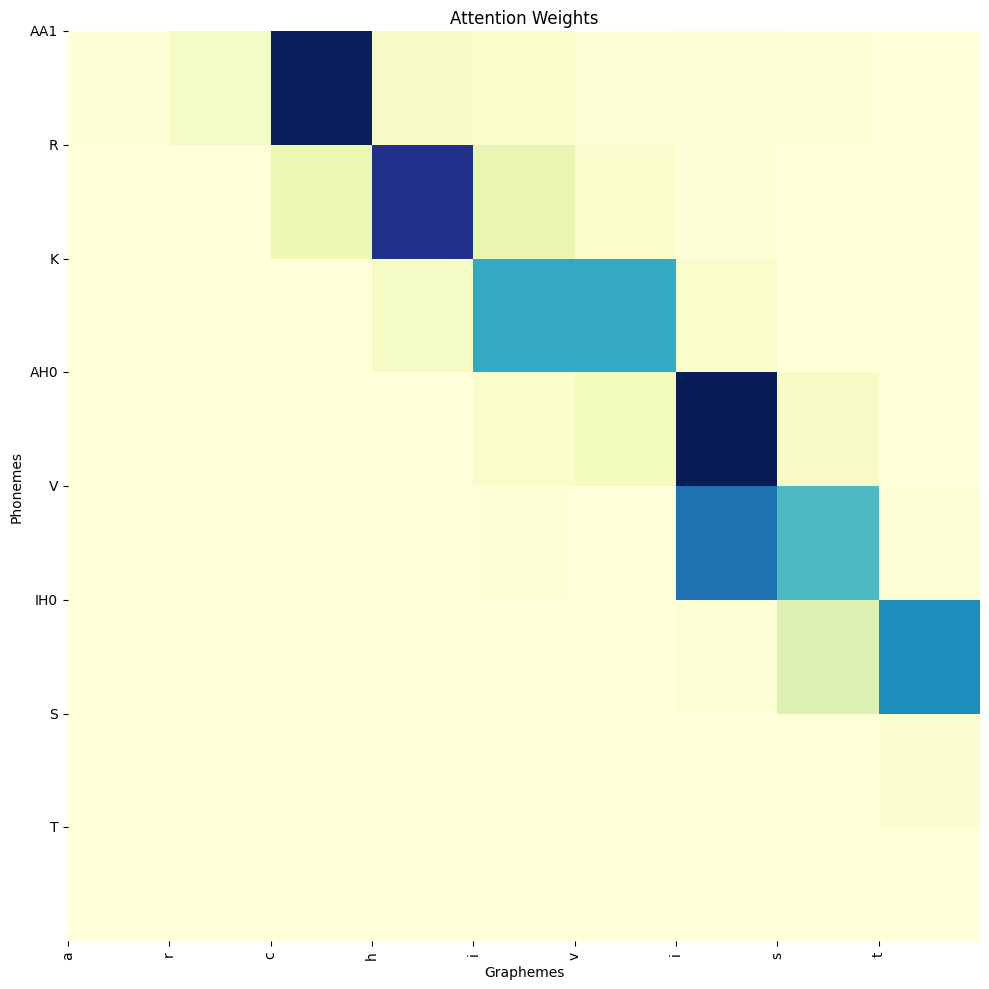

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def g2p_convert(model, word, grapheme2idx, idx2phoneme, phoneme2idx, device, max_length=50):
    model.eval()
    
    graphemes = ['<sos>'] + list(word.lower()) + ['<eos>']
    grapheme_indices = [grapheme2idx.get(char, grapheme2idx['<sos>']) for char in graphemes]
    grapheme_tensor = torch.LongTensor(grapheme_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(grapheme_tensor)

    outputs = []
    attentions = []
    x = torch.tensor([phoneme2idx['<sos>']]).to(device)

    for _ in range(max_length):
        output, hidden, cell, attn_weights = model.decoder(x, hidden, cell, encoder_outputs)
        
        predicted = output.argmax(1)
        
        if predicted.item() == phoneme2idx['<eos>']:
            break

        outputs.append(predicted.item())
        attentions.append(attn_weights.squeeze(0).cpu().detach().numpy())
        x = predicted

    phonemes = [idx2phoneme[idx] for idx in outputs]
    return ' '.join(phonemes), np.array(attentions)

def plot_attention(word, phonemes, attention):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Prepare input and output tokens
    input_tokens = list(word.lower())
    output_tokens = phonemes.split()

    # Ensure attention has the correct shape (target_length x source_length)
    attention = attention[:len(output_tokens), :len(input_tokens)]

    # Plot attention heatmap
    sns.heatmap(attention, cmap='YlGnBu', ax=ax, cbar=False)

    # Manually set the tick positions to match the tokens
    ax.set_xticks(np.arange(len(input_tokens)))
    ax.set_yticks(np.arange(len(output_tokens)))

    # Set the tick labels to the tokens
    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_tokens, rotation=0)

    ax.set_xlabel('Graphemes')
    ax.set_ylabel('Phonemes')
    ax.set_title('Attention Weights')

    plt.tight_layout()
    plt.show()

# Example test (assuming model and vocab are defined and on appropriate device)
test_word = "archivist"
phonemes, attentions = g2p_convert(model, test_word, grapheme2idx, idx2phoneme, phoneme2idx, device)

print(f"Input word: {test_word}")
print(f"Phonemes: {phonemes}")

plot_attention(test_word, phonemes, attentions)